In [44]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, SpatialDropout2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import os
from azure.storage.blob import ContainerClient, BlobClient
from io import BytesIO

In [ ]:

X_blob_url = os.getenv("AZURE_X_BLOB_URL")
y_blob_url = os.getenv("AZURE_Y_BLOB_URL")
print("📥 Downloading arrays directly from Azure...")

#Download directly into memory
X_stream = BytesIO(BlobClient.from_blob_url(X_blob_url).download_blob().readall())
y_stream = BytesIO(BlobClient.from_blob_url(y_blob_url).download_blob().readall())

# Load arrays
X = np.load(X_stream)
y = np.load(y_stream) - 1

num_classes = 5
print("✅ Loaded X and y directly from Azure.")
print("X shape:", X.shape)
print("y shape:", y.shape)

📥 Downloading arrays directly from Azure...
✅ Loaded X and y directly from Azure.
X shape: (14710, 128, 128, 3)
y shape: (14710,)


In [25]:

print("X dtype:", X.dtype)
print("y dtype:", y.dtype)


X dtype: uint8
y dtype: int64


Class 0: 3568 samples
Class 1: 2228 samples
Class 2: 2756 samples
Class 3: 3294 samples
Class 4: 2864 samples


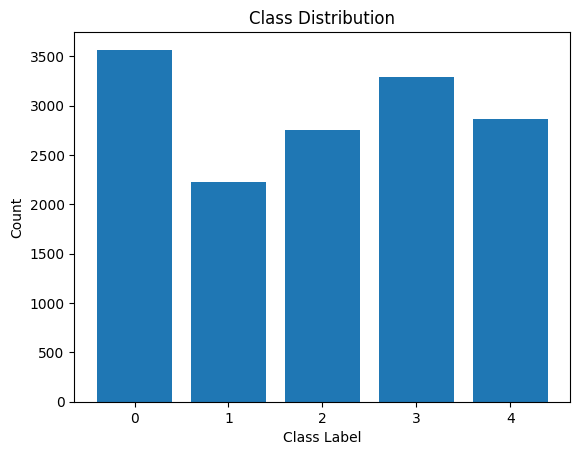

In [26]:
# Visualize number of images per each class 
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt} samples")

plt.bar(unique, counts)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


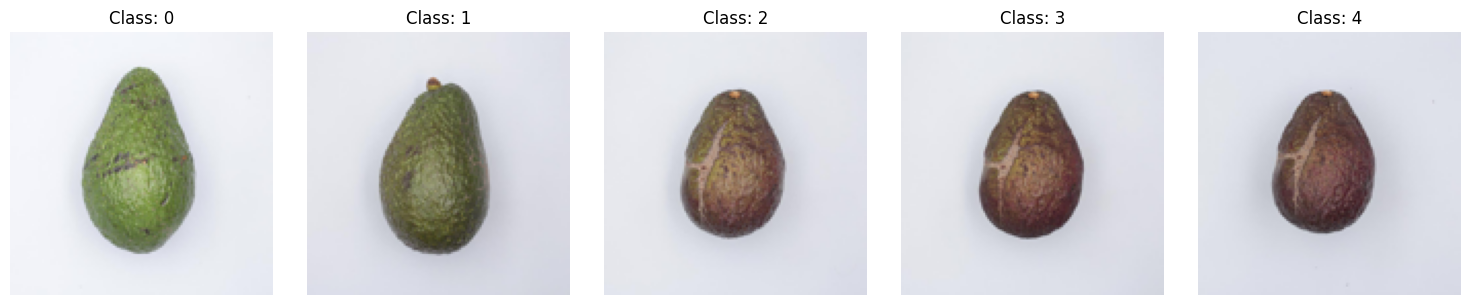

In [27]:
# Get unique classes
classes = np.unique(y)

# Images of avacado per each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))

for i, cls in enumerate(classes):
    # Find first index of this class
    idx = np.where(y == cls)[0][0]
    
    axes[i].imshow(X[idx])
    axes[i].set_title(f"Class: {cls}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


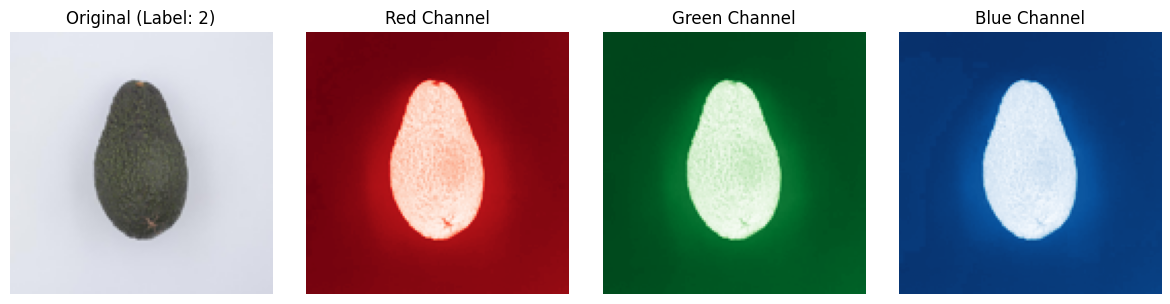

In [28]:
#Random image visualization with rgb colours
# Pick one image
idx = np.random.randint(0, len(X))
img = X[idx]

# Split into RGB channels
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]

# Plot all together
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img)
axes[0].set_title(f"Original (Label: {y[idx]})")
axes[0].axis("off")

axes[1].imshow(R, cmap="Reds")
axes[1].set_title("Red Channel")
axes[1].axis("off")

axes[2].imshow(G, cmap="Greens")
axes[2].set_title("Green Channel")
axes[2].axis("off")

axes[3].imshow(B, cmap="Blues")
axes[3].set_title("Blue Channel")
axes[3].axis("off")

plt.tight_layout()
plt.show()


In [29]:
#Image size
heights = [img.shape[0] for img in X]
widths = [img.shape[1] for img in X]
print(f"Unique heights: {set(heights)}")
print(f"Unique widths: {set(widths)}")


Unique heights: {128}
Unique widths: {128}


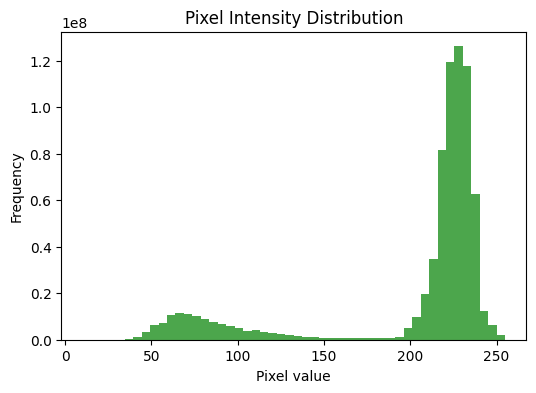

In [30]:
#Pixel intensity
plt.figure(figsize=(6,4))
plt.hist(X.flatten(), bins=50, color='green', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()


In [31]:
#Splitting data
X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=0.15, random_state=42, stratify=y ) 
X_train, X_val, y_train, y_val = train_test_split( X_train_val, y_train_val, test_size=0.18, random_state=42, stratify=y_train_val )

In [32]:
# Compute class weights (to make sure the model take equal amount of data from each class)
class_weights_values = compute_class_weight( 
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train ) 
class_weights = {i: w for i, w in enumerate(class_weights_values)}

In [33]:
#Data augmentation (to make model more robust by fine tuning)
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest' ) 
val_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
# Custom generator (creates batches of data for training instead of loading all images into RAM once)
def generator(X_data, y_data, batch_size=32):
    while True:
        indices = np.arange(len(X_data)) 
        np.random.shuffle(indices) 
        for i in range(0, len(indices), batch_size): 
            batch_idx = indices[i:i+batch_size] 
            batch_X = X_data[batch_idx].astype('float32') / 255.0 
            batch_y = to_categorical(y_data[batch_idx], num_classes) 
            sample_weights = np.array([class_weights[label] for label in y_data[batch_idx]]) 
            yield batch_X, batch_y, sample_weights 
train_gen = generator(X_train, y_train, batch_size=32) 
val_gen = generator(X_val, y_val, batch_size=32)


In [35]:
#CNN model
model = Sequential([ 
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)), 
    BatchNormalization(), 
    MaxPooling2D(2,2), 
    
    Conv2D(64, (3,3), activation='relu', padding='same'), 
    BatchNormalization(), 
    MaxPooling2D(2,2), 
    
    Conv2D(128, (3,3), activation='relu', padding='same'), 
    BatchNormalization(), 
    Dropout(0.2), 
    MaxPooling2D(2,2), 
    
    Conv2D(256, (3,3), activation='relu', padding='same'), 
    BatchNormalization(), 
    Dropout(0.3),  
    MaxPooling2D(2,2), 
    
    GlobalAveragePooling2D(), 
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    Dropout(0.4), 
    Dense(num_classes, activation='softmax') 
    ])

c:\Users\gayat\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Compile 
model.compile( 
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'] 
    )

In [37]:
# Callbacks 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [38]:
#Model fit
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_gen,
    validation_steps=len(X_val) // 32,
    epochs=30,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

val_accuracies = history.history['val_accuracy']
best_epoch = np.argmax(val_accuracies)  # index of highest val_accuracy
best_train_acc = history.history['accuracy'][best_epoch]
best_val_acc = val_accuracies[best_epoch]

Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.5663 - loss: 1.1951 - val_accuracy: 0.1513 - val_loss: 2.8658 - learning_rate: 1.0000e-04
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.6540 - loss: 0.9983 - val_accuracy: 0.3366 - val_loss: 1.7558 - learning_rate: 1.0000e-04
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 315s 985ms/step - accuracy: 0.6746 - loss: 0.9261 - val_accuracy: 0.6981 - val_loss: 0.9230 - learning_rate: 1.0000e-04
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.6929 - loss: 0.8815 - val_accuracy: 0.6336 - val_loss: 0.9722 - learning_rate: 1.0000e-04
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7072 - loss: 0.8590 - val_accuracy: 0.6404 - val_loss: 1.0659 - learning_rate: 1.0000e-04
Epoch 6/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.7157 - loss: 0.8294
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 303s 948ms/step - a

In [39]:
model.save("avocado_model.h5")



In [40]:
#Evaluate test accuracy

X_test_scaled = X_test.astype('float32') / 255.0
y_test_cat = to_categorical(y_test, num_classes)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=1)

print(f" Best Epoch: {best_epoch + 1}")  # +1 because index starts at 0
print(f" Training Accuracy at Best Epoch:   {best_train_acc:.4f}")
print(f" Validation Accuracy at Best Epoch: {best_val_acc:.4f}")
print(f" Test Accuracy:{test_acc:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7431 - loss: 0.7262
 Best Epoch: 18
 Training Accuracy at Best Epoch:   0.7800
 Validation Accuracy at Best Epoch: 0.7400
 Test Accuracy:0.7431


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step

🔹 Confusion Matrix:
[[466  69   0   0   0]
 [ 38 265  30   1   0]
 [  0  69 234 105   6]
 [  0   3  46 371  74]
 [  0   1   0 125 304]]


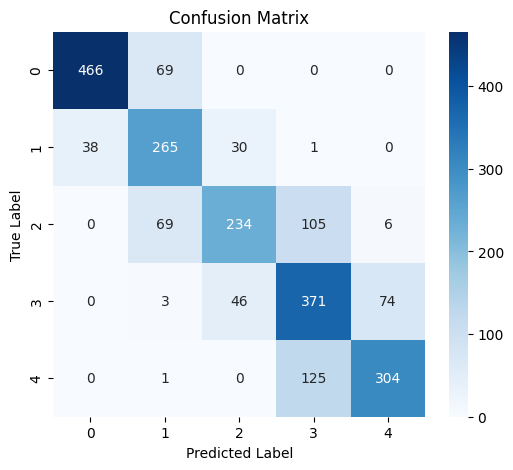

In [41]:
# Predict class probabilities
y_pred_probs = model.predict(X_test_scaled)

# Convert probabilities → predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🔹 Confusion Matrix:")
print(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
# Classification report
report = classification_report(y_test, y_pred)
print("\n🔹 Classification Report:")
print(report)


🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       535
           1       0.65      0.79      0.72       334
           2       0.75      0.57      0.65       414
           3       0.62      0.75      0.68       494
           4       0.79      0.71      0.75       430

    accuracy                           0.74      2207
   macro avg       0.75      0.74      0.74      2207
weighted avg       0.76      0.74      0.74      2207

